# Mission

Le projet porte sur StackOverFlow, la célèbre plateforme de questions et réponses populaire pour les développeurs.  
La mission est de développer un système qui génère les suggestions de tags lorsqu'un utilisateur pose une question sur le site. 
Le projet se décline sous forme de 4 notebooks:  
- un notebook avec un test du wrapper StackAPI pour récupérer 50 questions StackOverFlow     
- un notebook d'exploration et de pré-traitement des questions récupérées   
- un notebook avec une approche non supervisée de génération de tags     
- un notebook avec une approche supervisée de génération de tags    

# Génération de tags - Modèles supervisés 

1. [Importation des bibliothèques](#Importation-des-Bibliothèques)
    - [Configuration de MLFLow](#OneVsRestClassifier)  
    `MLFlow` est une plateforme open source de gestion du cycle de vie des modèles de machine learning qui offre plusieurs fonctionnalités comme le tracking d'expérimentations, la gestion de modèles, etc.
    - [Enregistrement d'une expérimentation](#LogisticRegression)  
    On démarre une `expérimentation` en utilisant MLflow. Chaque expérimentation peut contenir plusieurs `runs`.
2. [Chargement et prétraitement des données](#Chargement-et-Prétraitement-des-Données)
3. [Analyse de la fréquence des tags](#Analyse-de-la-Fréquence-des-Tags)
4. [Vectorisation des données textuelles et enregistrement des hyperparamètres avec MLFlow](#Vectorisation-des-Données-Textuelles)  
5. [Division des données en ensembles d'entraînement et de test](#Division-des-Données-en-Ensembles-d'Entraînement-et-de-Test)
6. [Préparation des modèles](#Entraînement-des-Modèles)
    - [Entraînement des modèles avec OneVsRestClassifier](#OneVsRestClassifier)  
    `OneVsRestClassifier` est une stratégie qui permet de traiter les problèmes de classification multiclasse ou multilabel. Pour chaque label, un modèle distinct est formé avec des exemples positifs pour ce label et des exemples négatifs pour tous les autres labels.  
    - [Fonction de comparaison des tags prédits et des tags réels](#comparaison-tags)  
    Permet d'afficher un tableau pour comparer les tags prédits et réels.
    - [Évaluation des modèles](#evaluation-modeles)  
    Les `Vrais Positifs, Vrais Négatifs, Faux Positifs, Faux Négatifs` permettent de calculer plusieurs métriques: `Accuracy, Precision, Recall, Jaccard, Score F1`.  
    Création d'une fonction de calcul des métriques avec sklearn.metrics
7. [LogisticRegression](#LogisticRegression)  
    `LogisticRegression` est un modèle qui est utilisé pour prédire la probabilité d'un événement binaire. Dans le contexte de la classification multiclasse ou multilabel, il est souvent utilisé avec `OneVsRestClassifier` pour entraîner un modèle pour chaque classe.  
    - [Entraînement du modèle](#entrainement-logisticr)  
    On utilise `predict_proba` pour à chaque fois sortir une série de prédiction de 5 tags, ceux avec qui ressortent avec la plus grande probabilité de prédiction.  
    - [Comparaison des tags prédits et des tags réels](#comparaison-tags)  
    Enregistrement du fichier comme artefact avec MLFlow.
    - [Suivi d'une expérimentation avec MLFlow](#evaluation-modeles)  
    Création d'un `run` pour enregitrer les métriques et les paramètres.
8. [SGDClassifier](#SGDClassifier)  
    `SGDClassifier` est un classificateur linéaire entraîné avec un apprentissage par descente de gradient stochastique. Il est utile pour les grandes échelles de données et supporte différentes fonctions de perte et pénalités pour la classification.  
    - [Entraînement du modèle](#entrainement-logisticr)  
    Utilisation de la `fonction de perte 'log'` pour un calcul des probabilités dans les prédictions de tags afin de sortir une série de 5 tags pour chaque question.    
    - [Comparaison des tags prédits et des tags réels](#comparaison-tags)  
    Enregistrement du fichier comme artefact avec MLFlow.
    - [Suivi d'une expérimentation avec MLFlow](#evaluation-modeles)  
    Création d'un `run` pour enregitrer les métriques et les paramètres.  


9. [Stockage des modèles dans le Model Registry](#stockage-des-modèles-dans-le-model-registry)  
   Enregistrement des modèles dans le Model Registry de MLflow pour une gestion facile des versions.

10. [Analyse de la stabilité du modèle dans le temps](#analyse-de-la-stabilité-du-modèle-dans-le-temps)  
   Comparaison de l'évolution des mesures et scores pour plusieurs séries mensuelles de questions (sur 6 mois), et stockage des résultats dans MLFlow tracking.
    
11. [Entraînement du modèle Word2Vec](#entraînement-du-modèle-word2vec)  
   Développement d'un modèle Word2Vec pour la représentation vectorielle des mots.

12. [Création et entraînement du modèle de réseau de neurones](#section12)  
   Construction et entraînement d'un modèle de réseau de neurones pour la classification des questions.

13. [Visualisation T-SNE](#section13)  
   Utilisation de la technique T-SNE pour visualiser les données en dimensions réduites.

14. [Extraction des caractéristiques avec BERT](#section14)  
   Utilisation du modèle BERT pour extraire des caractéristiques textuelles avancées.

15. [Extraction des caractéristiques avec USE](#section15)  
   Emploi du Universal Sentence Encoder pour obtenir des représentations vectorielles des phrases.


## 1.Importation des bibliothèques

Installation des bibliothèques suivantes :  
ipykernel==6.26.0  
pandas==2.1.3    
matplotlib==3.8.2  
scikit-learn==1.3.2  
joblib==1.3.2  
mlflow==2.8.1  
tensorflow==2.15.0  
gensim==4.3.2  
transformers==4.35.2  
tensorflow-hub==0.15.0

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

#### Configuration de MLFlow

In [25]:
import mlflow

# Définition de l'URI par défaut pour stocker les données
mlflow.set_tracking_uri("mlruns")

print("URI de suivi actuel:", mlflow.get_tracking_uri())


URI de suivi actuel: mlruns


#### Enregistrement d'une expérimentation
On démarre une expérimentation en utilisant MLflow. Chaque expérimentation peut contenir plusieurs "runs" :

In [ ]:
# Initialisation de l'expérience
mlflow.set_experiment("StackOverflow_Tag_Prediction")

## 2.Chargement et prétraitement des données

In [27]:
questions = pd.read_csv("dataset/questions_cleaned_stackoverflow.csv")

questions['Tags_list'] = questions['Tags'].str.split(',')
questions['Question_list'] = questions['Question_bow'].str.split(',')
questions.shape


(30582, 17)

In [28]:
questions[['Tags_list','Question_list']].sample(5)

,Tags_list,Question_list
29188,"[c, audio, memory-management, deep-copy, porta...","[memory, problem, audio, code, system, re..."
30510,"[java, class, oop, object, static]","[create, class, method, practice, code, t..."
13205,"[c#, unit-testing, asynchronous, ado.net, asyn...","[unit, test, async, method, problem, try,..."
4982,"[java, docker, security, checkmarx, secure-cod...","[path, traversal, issue, checkmarx, hf11, ..."
23820,"[parsing, go, lex, flex-lexer, lexer]","[semicolon, insertion, google, flex, colon..."


## 3.Analyse de la fréquence des tags
L'analyse de la fréquence des tags aide à identifier les tags les plus courants dans le dataset. 


In [29]:
from collections import Counter
from itertools import chain

tag_frequencies = Counter(chain.from_iterable(questions['Tags_list']))

top_200_tags = {tag for tag, count in tag_frequencies.most_common(200)}

filtered_df = questions[questions['Tags_list'].apply(lambda tags: all(tag in top_200_tags for tag in tags))]
questions = filtered_df
print(questions.shape)
top_200_tags


(1074, 17)


{'.net',
 '.net-core',
 'ajax',
 'algorithm',
 'amazon-web-services',
 'android',
 'android-fragments',
 'android-layout',
 'android-studio',
 'angular',
 'angularjs',
 'apache',
 'arrays',
 'asp.net',
 'asp.net-core',
 'asp.net-mvc',
 'asp.net-web-api',
 'assembly',
 'async-await',
 'asynchronous',
 'authentication',
 'azure',
 'bash',
 'boost',
 'browser',
 'c',
 'c#',
 'c++',
 'c++11',
 'c++14',
 'c++17',
 'caching',
 'casting',
 'clang',
 'class',
 'cocoa-touch',
 'compiler-construction',
 'compiler-optimization',
 'concurrency',
 'cordova',
 'css',
 'data-structures',
 'database',
 'date',
 'datetime',
 'debugging',
 'delphi',
 'dependency-injection',
 'dictionary',
 'django',
 'docker',
 'dom',
 'eclipse',
 'ecmascript-6',
 'encryption',
 'entity-framework',
 'excel',
 'exception',
 'express',
 'file',
 'firebase',
 'firefox',
 'floating-point',
 'flutter',
 'forms',
 'function',
 'functional-programming',
 'g++',
 'garbage-collection',
 'gcc',
 'generics',
 'git',
 'google-chrom

## 4. Vectorisation des données textuelles et enregistrement des hyperparamètres avec MLFlow
La vectorisation transforme le texte en un format numérique utilisable par les modèles d'apprentissage automatique.


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

X = questions["Question_list"]
y = questions["Tags_list"]

with mlflow.start_run():
    # Configuration et entraînement du TfidfVectorizer
    vectorizer = TfidfVectorizer(analyzer="word",
                                 max_df=.6,
                                 min_df=0.0001,
                                 tokenizer=None,
                                 preprocessor=' '.join,
                                 stop_words=None,
                                 lowercase=False)
    vectorizer.fit(X)

    # Consignation des paramètres du vectoriseur
    mlflow.log_params(vectorizer.get_params())

Sauvegarde de l'objet vectorizer avec la librairie joblib.

In [31]:
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

On sauvegardera de même multilabelbinazer et les modèles (après entraînement) pour les réutiliser lors de l'analyse de stabilité (évolution des métriques du modèle mois par mois) et également pour utilisation dans l'api flask.  
Par exemple, joblib.load('tfidf_vectorizer.joblib') permettra de transformer les questions entrantes en vecteurs TF-IDF de la même manière que lors de l'entraînement du modèle.

In [32]:
X_tfidf = vectorizer.transform(X)
print("Format de X (questions): {}".format(X_tfidf.shape))

Format de X (questions): (1074, 4911)


In [33]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
joblib.dump(multilabel_binarizer, 'multilabel_binarizer.joblib')

['multilabel_binarizer.joblib']

In [34]:
y_binarized = multilabel_binarizer.transform(y)
print("Format de y (tags): {}".format(y_binarized.shape))

Format de y (tags): (1074, 196)


## 5. Division des données en ensembles d'entraînement et de test

In [ ]:
from sklearn.model_selection import train_test_split

# train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train : {}".format(X_train.shape))
print("X_test : {}".format(X_test.shape))
print("y_train : {}".format(y_train.shape))
print("y_test : {}".format(y_test.shape))

X_train : (751, 4911)
X_test : (323, 4911)
y_train : (751, 196)
y_test : (323, 196)


## 6. Entraînement des modèles  
### OneVsRestClassifier  
Dans cette section, nous entraînons des modèles de classification multilabel en utilisant la stratégie One-vs-Rest.  
`OneVsRestClassifier` est une stratégie qui permet de traiter les problèmes de classification multiclasse ou multilabel.  
Pour chaque label, un modèle distinct est formé avec des exemples positifs pour ce label et des exemples négatifs pour tous les autres labels.  
Nous commençons par la régression logistique.


### Comparaison des tags prédits et des tags réels

In [ ]:
def inverse_transform_and_update(y_test_top5_indices, y_test, df=None, predicted_col_name='Predicted', true_col_name='True'):
    # transformation des indices en noms de tags pour les prédictions
    y_test_pred_tags = [multilabel_binarizer.classes_[indices] for indices in y_test_top5_indices]
    
    # transformation inverse des tags réels
    y_test_true_tags = multilabel_binarizer.inverse_transform(y_test)
    
    new_data = {
        true_col_name: y_test_true_tags,
        predicted_col_name: y_test_pred_tags
    }
    new_df = pd.DataFrame(new_data)
    
    if df is None:
        return new_df
    else:
        df[true_col_name] = new_df[true_col_name]
        df[predicted_col_name] = new_df[predicted_col_name]
        return df


### Évaluation des modèles



Nous évaluons la performance des modèles en utilisant différentes métriques pertinentes pour les problèmes de classification multilabel.  
Ces métriques sont calculées à partir de la matrice de confusion

`La matrice de confusion`   
Une **matrice de confusion** répartit les résultats de classification en:
- Vrais Positifs (VP)
- Vrais Négatifs (VN)
- Faux Positifs (FP)
- Faux Négatifs (FN)  

`Cette matrice de confusion est à l'origine de plusieurs métriques:`   

`Accuracy`  
Le **score de précision** indique le pourcentage de prédictions correctes qui ont été faites. Cette métrique, bien qu'utile, présente des limites, surtout en présence de **classes déséquilibrées**.  
Accuracy=(VP+VN)​/(VP+VN+FP+FN)  

`Précision`  
La **précision** est une métrique qui pénalise les modèles générant de nombreux **faux positifs**. Une précision de 1 est synonyme de perfection.  
Precision=VP/(VP+FP)  

`Rappel (ou sensibilité ou recall)`  
Le **rappel**, ou **sensibilité**, pénalise les modèles qui produisent des **faux négatifs**. Un rappel de 1 reflète une performance sans erreur.  
VP/(VP+FN)  

`Score F1`  
Le **score F1** offre un équilibre entre la précision et le rappel, constituant ainsi une mesure robuste. Un score F1 de 1 représente la moyenne harmonique de la précision et du rappel.  
Score F1= 2x(PrécisionxRappel)/(Précision+Rappel)=2VP/(2VP+FP+FN)  

`Score de Jaccard`  
Le **score de Jaccard** représente le rapport entre la taille de l'intersection et la taille de l'union des 2 ensembles d'étiquettes (les prédites et les vraies). Le score de Jaccard n'inclut pas les vrais négatifs dans son calcul. Cela le rend particulièrement utile dans les situations où les VN ne sont pas pertinents ou quand on veut se focaliser uniquement sur la performance de la classification positive.  
Score de Jaccard=VP/(VP+FP+FN)


#### Calcul des métriques avec sklearn.metrics

In [37]:
import sklearn.metrics as metrics

def metrics_score(model, y_true, y_pred, df=None):
    scores = {
        "Accuracy": metrics.accuracy_score(y_true, y_pred),
        "F1": metrics.f1_score(y_true, y_pred, average='weighted', zero_division=0),
        "Jaccard": metrics.jaccard_score(y_true, y_pred, average='weighted', zero_division=0),
        "Precision": metrics.precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "Recall": metrics.recall_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    
    if df is None:
        df = pd.DataFrame(scores, index=[model]).T
    else:
        df[model] = scores.values()
    
    return df

## 7. LogisticRegression


In [ ]:
### Entraînement des Modèles

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

ovr_logreg = OneVsRestClassifier(LogisticRegression())
ovr_logreg.fit(X_train, y_train)

joblib.dump(ovr_logreg, 'logreg_classifier_model.joblib')

In [ ]:
# probas pour chaque classe
y_test_proba_logreg = ovr_logreg.predict_proba(X_test)

# 5 indices de classe les plus probables pour chaque exemple
y_test_top5_indices = np.argsort(y_test_proba_logreg, axis=1)[:, -5:]

In [40]:
df_tags_predicted_logreg = inverse_transform_and_update(y_test_top5_indices, y_test, df=None, predicted_col_name='LogisticRegression', true_col_name='True')
df_tags_predicted_logreg.sample(10)

,True,LogisticRegression
296,"(c, compiler-construction, linux, performance,...","[optimization, c, c#, performance, c++]"
5,"(boost, ios, npm, react-native, xcode)","[c#, ios, java, javascript, c++]"
207,"(.net, asp.net-mvc, c#, generics, inheritance)","[javascript, .net, c++, java, c#]"
126,"(.net, c#, unit-testing, visual-studio, visual...","[java, performance, .net, c++, c#]"
186,"(c++, c++17, g++, lambda, templates)","[c#, c++11, java, gcc, c++]"
73,"(asp.net, c#, css, javascript, jquery)","[c#, css, html, javascript, jquery]"
234,"(ios, node.js, objective-c, react-native, reac...","[ios, c++, c#, java, javascript]"
263,"(.net-core, c#, database, sql, sql-server)","[sql-server, asp.net, java, javascript, c#]"
119,"(css, dom, html, javascript, jquery)","[performance, css, jquery, html, javascript]"
189,"(c++, c++14, c++17, language-lawyer, pointers)","[javascript, c++11, c, language-lawyer, c++]"


#### Enregistrement du fichier comme artefact avec MLFlow

In [41]:
file_name = "predicted_tags.csv"
df_tags_predicted_logreg.to_csv(file_name, index=False)

In [42]:
with mlflow.start_run():
    mlflow.log_artifact(file_name)

In [43]:
def transform_top5_to_binary(y_test_top5_indices, num_classes):
    y_pred_binary = np.zeros((len(y_test_top5_indices), num_classes))
    for i, indices in enumerate(y_test_top5_indices):
        y_pred_binary[i, indices] = 1
    return y_pred_binary

y_test_predicted_logreg_binary = transform_top5_to_binary(y_test_top5_indices, y_binarized.shape[1])

In [44]:
# Calcul des métriques avec les prédictions transformées
df_metrics_logreg = metrics_score("LogisticRegression", y_test, y_test_predicted_logreg_binary)

In [45]:
df_metrics_logreg

,LogisticRegression
Accuracy,0.012384
F1,0.329521
Jaccard,0.233161
Precision,0.352733
Recall,0.432198


In [ ]:
with mlflow.start_run(run_name="LogisticRegression") as run:
    # Enregistrement des paramètres
    mlflow.log_params({"model_type": "LogisticRegression", "max_df": .6, "min_df": 0.005})
    
    # Entraînement du modèle
    ovr_logreg.fit(X_train, y_train)

    # Enregistrement des métriques
    mlflow.log_metrics({
        "Accuracy": metrics.accuracy_score(y_test, y_test_predicted_logreg_binary),
        "F1": metrics.f1_score(y_test, y_test_predicted_logreg_binary, average='weighted', zero_division=0),
        "Jaccard": metrics.jaccard_score(y_test, y_test_predicted_logreg_binary, average='weighted', zero_division=0),
        "Precision": metrics.precision_score(y_test, y_test_predicted_logreg_binary, average='weighted', zero_division=0),
        "Recall": metrics.recall_score(y_test, y_test_predicted_logreg_binary, average='weighted', zero_division=0)
    })

    # Enregistrement du modèle
    mlflow.sklearn.log_model(ovr_logreg, "logistic_regression_model")


## 8. SGDClassifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

# utilisation de la fonction de perte 'log' pour le calcul des probabilités
ovr_sgd = OneVsRestClassifier(SGDClassifier(loss='log_loss'))
ovr_sgd.fit(X_train, y_train)

joblib.dump(ovr_sgd, 'sgd_classifier_model.joblib')


In [48]:
y_test_proba_sgd = ovr_sgd.predict_proba(X_test)
y_test_top5_sgd_indices = np.argsort(y_test_proba_sgd, axis=1)[:, -5:]

In [49]:
df_tags_predicted_sgd = inverse_transform_and_update(y_test_top5_sgd_indices, y_test, df=None, predicted_col_name='SGDClassifier', true_col_name='True')
df_tags_predicted_sgd.sample(10)

,True,SGDClassifier
192,"(docker, java, jvm, linux, memory)","[c++, linux, memory-leaks, memory-management, ..."
151,"(ajax, asp.net-mvc, c#, jquery, json)","[jquery, json, c#, ajax, asp.net-mvc]"
10,"(ajax, javascript, mysql, php, utf-8)","[web-services, c#, javascript, jquery, ajax]"
269,"(assembly, c++, clang, compiler-optimization, ...","[gcc, assembly, c, optimization, c++]"
175,"(asp.net, asp.net-web-api, c#, iis, javascript)","[ajax, .net, javascript, asp.net, c#]"
247,"(arrays, matlab, numpy, performance, python)","[c++, performance, optimization, numpy, python]"
100,"(ajax, android, cordova, javascript, jquery)","[java, jquery, ajax, javascript, json]"
203,"(c, floating-point, gcc, performance, x86)","[c, optimization, performance, python, c++]"
306,"(c++, c++11, multithreading, visual-c++, visua...","[gcc, c, templates, c++11, c++]"
149,"(arrays, numpy, performance, python, python-2.7)","[list, numpy, python-3.x, arrays, python]"


In [50]:
df_combined = df_tags_predicted_logreg.copy() 
df_combined['SGDClassifier'] = df_tags_predicted_sgd['SGDClassifier']

df_combined.sample(10)

,True,LogisticRegression,SGDClassifier
42,"(django, ios, json, node.js, python)","[java, json, jquery, c#, javascript]","[ajax, c#, json, python, javascript]"
133,"(arrays, c, c++, memory, pointers)","[java, javascript, arrays, c, c++]","[memory, language-lawyer, c, arrays, pointers]"
76,"(c++, c++11, lambda, visual-c++, visual-studio...","[c#, java, javascript, c++11, c++]","[visual-c++, c++14, c++11, c++, lambda]"
227,"(c++, caching, memory, performance, x86)","[optimization, c, c#, performance, c++]","[optimization, c++, c#, .net, performance]"
128,"(ajax, cordova, javascript, jquery, php)","[java, ajax, c#, jquery, javascript]","[c#, json, ajax, jquery, javascript]"
179,"(css, html, javascript, jquery, twitter-bootst...","[java, c++, c#, jquery, javascript]","[c#, css, twitter-bootstrap, jquery, javascript]"
40,"(angularjs, css, html, javascript, jquery)","[c++, css, html, jquery, javascript]","[node.js, css, html, jquery, javascript]"
46,"(css, html, ipad, javascript, jquery)","[c++, c#, html, jquery, javascript]","[google-chrome, css, html, jquery, javascript]"
191,"(c++, compiler-optimization, gcc, performance,...","[optimization, c, performance, gcc, c++]","[c, optimization, performance, gcc, c++]"
68,"(c++, inheritance, oop, stl, vector)","[performance, c#, vector, c++11, c++]","[templates, stl, vector, c++11, c++]"


In [51]:
y_test_predicted_sgd_binary = transform_top5_to_binary(y_test_top5_sgd_indices, y_binarized.shape[1])
df_metrics_sgd = metrics_score("SGDClassifier", y_test, y_test_predicted_sgd_binary)


In [52]:
df_metrics_sgd

,SGDClassifier
Accuracy,0.068111
F1,0.513140
Jaccard,0.382243
Precision,0.527212
Recall,0.559752


In [53]:
df_metrics_combined = df_metrics_logreg.copy() 
df_metrics_combined['SGDClassifier'] = df_metrics_sgd['SGDClassifier']
df_metrics_combined

,LogisticRegression,SGDClassifier
Accuracy,0.012384,0.068111
F1,0.329521,0.513140
Jaccard,0.233161,0.382243
Precision,0.352733,0.527212
Recall,0.432198,0.559752


In [ ]:
with mlflow.start_run(run_name="SGDClassifier") as run:

    mlflow.log_params({"model_type": "SGDClassifier", "loss": "log"})
    
    ovr_sgd.fit(X_train, y_train)

    mlflow.log_metrics({
        "Accuracy": metrics.accuracy_score(y_test, y_test_predicted_sgd_binary),
        "F1": metrics.f1_score(y_test, y_test_predicted_sgd_binary, average='weighted', zero_division=0),
        "Jaccard": metrics.jaccard_score(y_test, y_test_predicted_sgd_binary, average='weighted', zero_division=0),
        "Precision": metrics.precision_score(y_test, y_test_predicted_sgd_binary, average='weighted', zero_division=0),
        "Recall": metrics.recall_score(y_test, y_test_predicted_sgd_binary, average='weighted', zero_division=0)
    })

    mlflow.sklearn.log_model(ovr_sgd, "sgd_classifier_model")
    # print("Run ID:", run.info.run_id)


## 9. Stockage des modèles dans le Model Registry
<p>Enregistrement des modèles dans le Model Registry de MLflow pour une gestion facile des versions</p>

In [ ]:
mlflow.register_model(
    # remplacer <RUN_ID> par l'ID du run approprié
    "runs:/<RUN_ID>/logistic_regression_model",
    "LogisticRegressionModel"
)

mlflow.register_model(
    # remplacer <RUN_ID> par l'ID du run approprié
    "runs:/<RUN_ID>/sgd_classifier_model",
    "SGDClassifierModel"
)

## 10. Analyse de la stabilité du modèle dans le temps

### Comparaison de l'évolution des mesures et scores pour plusieurs séries mensuelles de questions (sur 6 mois), et stockage des résultats dans MLFlow tracking.

`Pour ce faire, on extrait 6 datasets du site https://data.stackexchange.com/stackoverflow/query/new, on filtre ces datasets pour plusieurs période de 1 mois. Les datasets récents contiennent peu de données (environ une trentaine par mois avec filtre des scores, vues..). On prendra plutôt des datasets de 2015 qui sont davantage fournis. Après filtre des scores, vues, tags..., à peu près 300 à 400 questions sont recueillies par mois.`   
  
#### On fait par exemple la requête SQL suivante pour le mois d'avril 2015:  
   
SELECT TOP 50000  
    &nbsp;&nbsp;&nbsp;&nbsp;P.Id AS PostId,  
    &nbsp;&nbsp;&nbsp;&nbsp;P.Title,  
    &nbsp;&nbsp;&nbsp;&nbsp;P.Body,  
    &nbsp;&nbsp;&nbsp;&nbsp;P.Tags,  
    &nbsp;&nbsp;&nbsp;&nbsp;P.ViewCount,  
    &nbsp;&nbsp;&nbsp;&nbsp;P.CommentCount,  
    &nbsp;&nbsp;&nbsp;&nbsp;P.AnswerCount,  
    &nbsp;&nbsp;&nbsp;&nbsp;P.Score  
FROM Posts P  
WHERE (P.PostTypeId = 1) -- Questions  
AND (P.CreationDate BETWEEN '2015-04-01' AND '2015-04-30') -- Avril 2015  
AND (P.ViewCount IS NOT NULL) -- Nombreuses vues  
AND (P.CommentCount > 5) -- Nombreux commentaires  
AND (P.Score > 5) -- Bon score  
AND (P.AnswerCount > 0) -- Au moins une réponse  
AND (LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5) -- Au moins 5 tags  
ORDER BY P.ViewCount DESC;  
  
On remplace à chaque fois cette ligne    
`AND (P.CreationDate BETWEEN '2015-04-01' AND '2015-04-30') -- Avril 2015`    
pour obtenir les différents mois voulus de avril à septembre 2015.  

`Chacun de ces datasets est cleané avec le notebook d'analyse exploratoire et de cleaning.   
Il en ressort 6 datasets à exploiter dans ce modèle:`    
2015-4-cleaned.csv  
2015-5-cleaned.csv  
2015-6-cleaned.csv  
2015-7-cleaned.csv  
2015-8-cleaned.csv  
2015-9-cleaned.csv  



On récupère ensuite les fichiers vectorizer, multilabel_binarizer et le modèle sgd_classifier (le modèle le plus performant) qu'on avait sauvegardés avec joblib et qui auront le même entraînement (fit) pour les différents mois, afin qu'il n'y ait pas de data leakage. Les méthodes transform en revanche seront propres à chaque dataset.

In [ ]:
ovr_sgd = joblib.load("sgd_classifier_model.joblib")

# Chargement du vectorizer et du binarizer (déjà entraînés et sauvegardés)
vectorizer = joblib.load("tfidf_vectorizer.joblib")
multilabel_binarizer = joblib.load("multilabel_binarizer.joblib")

# Boucle sur les séries mensuelles
for month in range(4, 10):
    questions_month = pd.read_csv(f"dataset/2015-{month}-cleaned.csv")
    questions_month['Question_list'] = questions_month['Question_bow'].str.split(',')

    X_month = questions_month["Question_list"]
    y_month = questions_month["Tags_list"]

    # Filtre de 200 tags
    filtered_df = questions_month[questions_month['Tags_list'].apply(lambda tags: all(tag in top_200_tags for tag in tags))]
    questions_month = filtered_df

    # Transformation des données
    X_month_tfidf = vectorizer.transform(X_month)
    y_month_binarized = multilabel_binarizer.transform(y_month)

    X_train_month, X_test_month, y_train_month, y_test_month = train_test_split(X_month_tfidf, y_month_binarized,
                                                    test_size=0.3, random_state=8)

    # application de predict_proba au modèle
    y_test_proba_sgd_month = ovr_sgd.predict_proba(X_test_month)
    y_test_top5_sgd_indices_month = np.argsort(y_test_proba_sgd_month, axis=1)[:, -5:]

    y_test_predicted_sgd_binary_month = transform_top5_to_binary(y_test_top5_sgd_indices_month, y_month_binarized.shape[1])


    # Calcul des métriques
    accuracy = metrics.accuracy_score(y_test_month, y_test_predicted_sgd_binary_month)
    f1 = metrics.f1_score(y_test_month, y_test_predicted_sgd_binary_month, average='weighted')
    jaccard = metrics.jaccard_score(y_test_month, y_test_predicted_sgd_binary_month, average='weighted')
    precision = metrics.precision_score(y_test_month, y_test_predicted_sgd_binary_month, average='weighted')
    recall = metrics.recall_score(y_test_month, y_test_predicted_sgd_binary_month, average='weighted')


    # Enregistrement des métriques dans MLFlow afin d'avoir un tracking sur 6 mois
    with mlflow.start_run(run_name=f"Performance_Month_{month}"):
        mlflow.log_metrics({
            "Accuracy": accuracy,
            "F1": f1,
            "Jaccard": jaccard,
            "Precision": precision,
            "Recall": recall
        })

Voici les captures d'écran des différentes métriques recueilles sur l'interface de mlflow, via la commande mlflow ui, pour les mois d'avril à septembre 2015.

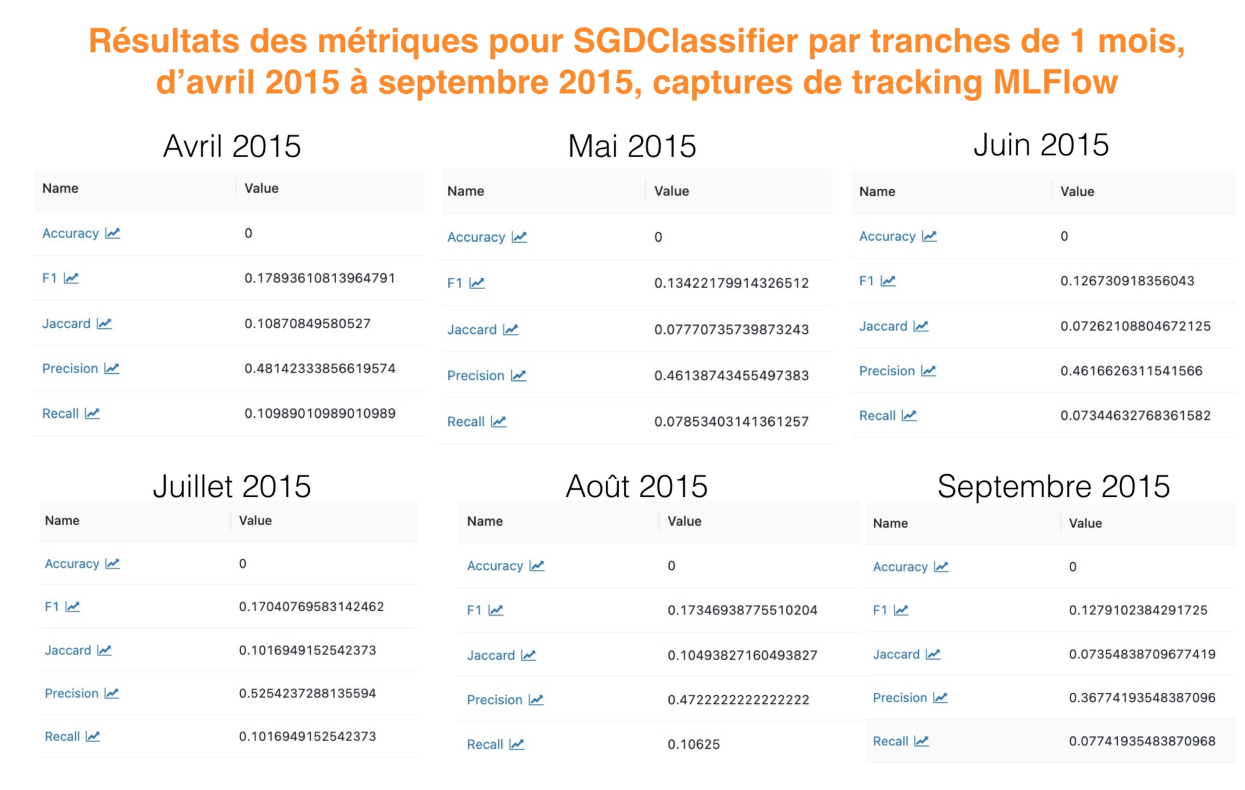

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = 'images/mlflow-evolution.jpg'
img = mpimg.imread(image_path)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

On constate une certaine cohérence dans l'évolution des différents scores.  
Les résultats du Score F1, de Jaccard, de Precision, et de Recall sont chaque mois, d'avril à septembre 2015, relativement dans une même échelle d'ordre de grandeur. Des écarts un peu plus significatifs à certains mois se réduisent parfois sur les mois suivants comme pour le score F1.  
Ces scores sont toutefois moins performants que ceux trouvés précédemment dans l'ensemble du dataset.  
Cela peut s'expliquer par le fait que les datasets pris mois par mois sont beaucoup moins denses, environ 300 lignes à l'issue des téléchargments de fichiers CSV, alors que le dataset entier était d'environ 30 000 lignes.

## 11. Entraînement du modèle Word2Vec
<p>Développement d'un modèle Word2Vec pour la représentation vectorielle des mots.</p>

In [36]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [37]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = questions['Title_emb'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [38]:
from gensim.models import Word2Vec
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 2210
Word2Vec trained


In [39]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 2211


In [ ]:
# création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (2211, 300)


## 12. Création et entraînement du modèle de réseau de neurones
<p>On définit la structure du modèle de réseau de neurones avec TensorFlow et Keras, après avoir préparé les données textuelles. On débute avec la définition des couches d'entrée, d'embedding, et de pooling, suivi par la construction complète du modèle et son entraînement.</p>

In [41]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         


                                                                 
 embedding (Embedding)       (None, 24, 300)           663300    
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 663300 (2.53 MB)
Trainable params: 663300 (2.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

34/34 [==============================] - 0s 1ms/step


(1074, 300)

In [43]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(questions['Tags_list'])

Liste des 200 tags les plus fréquents 

In [44]:
l_cat = list(top_200_tags)
print("catégories : ", l_cat)

catégories :  ['google-chrome', 'sql', 'asp.net-core', 'sorting', 'firefox', 'ubuntu', 'haskell', 'spring-mvc', 'boost', 'networking', 'wcf', 'recursion', 'react-native', 'laravel', 'unix', 'video', 'scala', 'python-2.7', 'unit-testing', 'garbage-collection', 'postgresql', 'floating-point', 'intellij-idea', 'visual-studio-2010', 'java-8', 'python', 'compiler-construction', 'maven', 'python-3.x', 'sockets', 'dependency-injection', 'entity-framework', 'git', 'swift', 'performance', 'objective-c', 'c++17', 'debugging', 'qt', '.net', 'vector', 'jquery', 'mongodb', 'jpa', 'lambda', 'assembly', 'concurrency', 'forms', 'ruby', 'angular', 'exception', 'date', 'excel', 'hibernate', 'android-fragments', 'utf-8', 'vb.net', 'machine-learning', 'c++14', 'gradle', 'optimization', 'clang', 'tomcat', 'android', 'c++11', 'cocoa-touch', 'stl', 'generics', 'npm', 'r', 'regex', 'http', 'loops', 'browser', 'sqlite', 'selenium', 'dom', 'opencv', 'asp.net-web-api', 'data-structures', 'functional-programming'

In [46]:
from sklearn.metrics import silhouette_score
import time
from sklearn import manifold, cluster

def silhouette_fct(features, y_bin):
    time1 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    # Utilisation de silhouette_score au lieu d'ARI
    silhouette_avg = silhouette_score(X_tsne, cls.labels_)
    
    time2 = np.round(time.time() - time1,0)
    print("Silhouette Score: ", silhouette_avg, "Time: ", time2)
    
    return silhouette_avg, X_tsne, cls.labels_

# Appel de la fonction avec y_bin
silhouette_avg, X_tsne, labels = silhouette_fct(embeddings, y_bin)

Silhouette Score:  0.39593858 Time:  15.0


## 13. Visualisation TSNE

In [47]:
import matplotlib.pyplot as plt

def TSNE_visu_fct(X_tsne, y_cat, labels, silhouette_avg):
    fig = plt.figure(figsize=(15, 6))

    # Visualisation selon les catégories réelles
    ax1 = fig.add_subplot(121)
    scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat, cmap='Set1')
    ax1.legend(*scatter1.legend_elements(), loc="best", title="Catégories")
    ax1.set_title('Représentation par catégories réelles')

    # Visualisation selon les clusters
    ax2 = fig.add_subplot(122)
    scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax2.legend(*scatter2.legend_elements(), loc="best", title="Clusters")
    ax2.set_title('Représentation par clusters')

    plt.show()
    print("Silhouette Score: ", silhouette_avg)


In [48]:
# dictionnaire pour mapper chaque combinaison unique de tags à un identifiant
unique_tag_combinations = {frozenset(tags): idx for idx, tags in enumerate(set(map(frozenset, questions['Tags_list'])))}

# Création d'une colonne 'y_cat' qui contient l'identifiant numérique pour chaque combinaison de tags
questions['y_cat'] = questions['Tags_list'].apply(lambda x: unique_tag_combinations[frozenset(x)])
y_cat = questions['y_cat'].to_numpy()


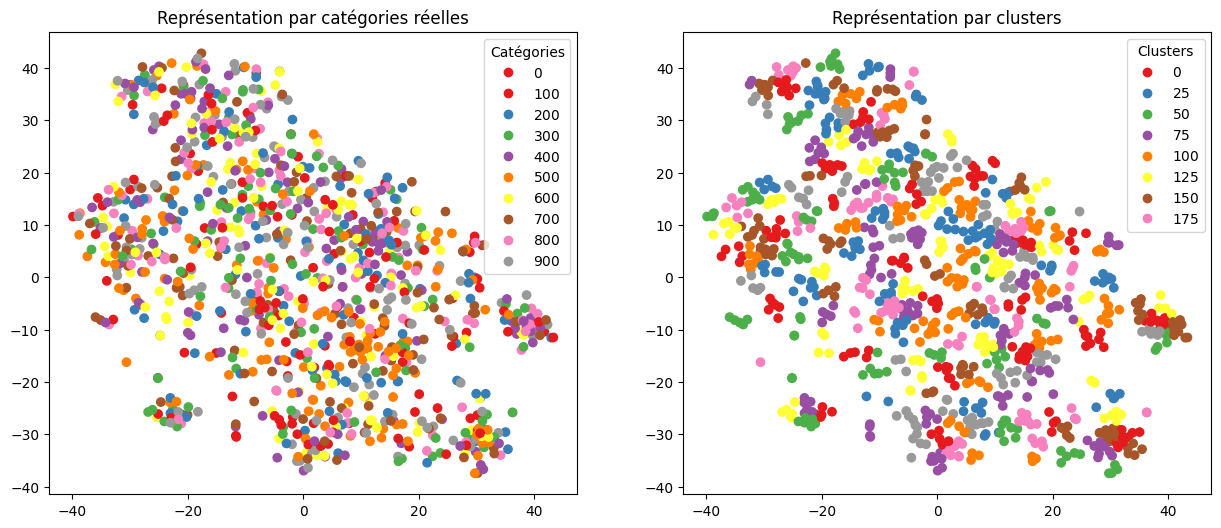

Silhouette Score:  0.39593858


In [49]:
TSNE_visu_fct(X_tsne, y_cat, labels, silhouette_avg)

## 14. Extraction des caractéristiques avec BERT
<p>Utilisation du modèle BERT pour extraire des caractéristiques textuelles avancées.</p>

In [ ]:
# Importation de BERT
from transformers import BertTokenizer, TFBertModel

bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)


In [52]:
# Prétraitement pour BERT
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

max_len = 24  # Choisissez une longueur appropriée
x_bert = bert_encode(questions['Title_emb'], bert_tokenizer, max_len=max_len)


In [53]:
# Extraction des caractéristiques avec BERT
def get_bert_embeddings(x_bert, bert_model):
    # Note : Cette opération peut être très coûteuse en temps de calcul
    inputs = {'input_ids': x_bert[0], 'attention_mask': x_bert[1], 'token_type_ids': x_bert[2]}
    outputs = bert_model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return last_hidden_states

bert_embeddings = get_bert_embeddings(x_bert, bert_model)



In [54]:
print(type(bert_embeddings))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [55]:
# Réduction des dimensions des embeddings de BERT
bert_embeddings_2d = tf.reduce_mean(bert_embeddings, axis=1)

# Vérification de la nouvelle forme
print("Nouvelle forme des embeddings de BERT :", bert_embeddings_2d.shape)


Nouvelle forme des embeddings de BERT : (1074, 768)


In [56]:
silhouette_avg_bert, X_tsne_bert, labels_bert = silhouette_fct(bert_embeddings_2d, y_bin)

Silhouette Score:  0.3538388 Time:  13.0


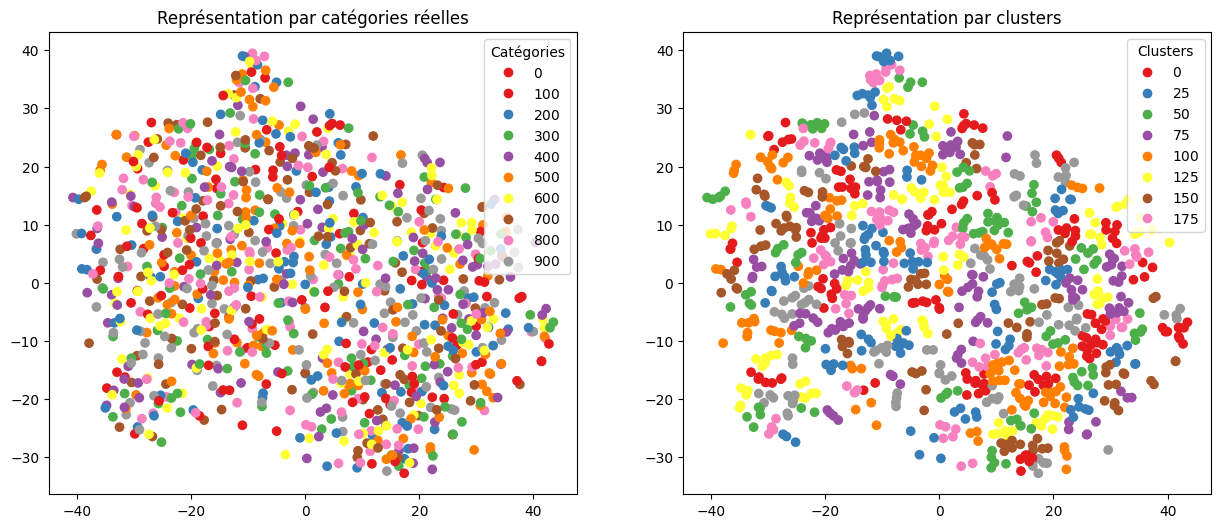

Silhouette Score:  0.3538388


In [57]:
TSNE_visu_fct(X_tsne_bert, y_cat, labels_bert, silhouette_avg_bert)

## 15. Extraction des caractéristiques avec USE
<p>Emploi du Universal Sentence Encoder pour obtenir des représentations vectorielles des phrases.</p>

In [59]:
# Importation de USE
import tensorflow_hub as hub

use_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(use_model_url)

In [60]:
# Exemple de texte
text = ["This is an example sentence."]
# Obtenir les embeddings
embeddings = use_model(text)
print(embeddings[0])

tf.Tensor(
[ 6.23825826e-02  2.08216850e-02  3.80545133e-03  2.92493533e-02
 -7.32270256e-02 -1.97312445e-03 -1.66500490e-02  3.30244675e-02
  6.92790328e-03  5.26215136e-02 -1.02989385e-02 -1.13194678e-02
 -6.23090751e-03  1.00084186e-01  1.80095732e-02 -9.93793309e-02
 -1.39244674e-02 -1.76650137e-02 -4.52030376e-02 -5.56310900e-02
  7.91292116e-02  3.78863290e-02 -1.52980918e-02 -5.07262768e-03
 -5.49592972e-02  7.23988861e-02  2.90205274e-02 -5.82795814e-02
 -5.40220179e-03 -1.69340763e-02  2.15250328e-02  8.37886706e-03
  5.60171856e-03 -1.65353734e-02 -9.10105407e-02 -2.74207406e-02
  5.25665246e-02  7.65372440e-03  6.13667537e-04 -2.69716755e-02
  4.83600376e-03  2.30624210e-02  6.15627095e-02  7.88372830e-02
 -5.29996753e-02 -3.27655710e-02  2.29131449e-02 -2.13254169e-02
 -2.20250897e-02  1.78520009e-02  2.50900928e-02 -6.34129643e-02
 -1.00854211e-01 -1.90065783e-02 -2.80478429e-02 -1.85554810e-02
 -6.91876262e-02  3.61712798e-02 -5.96615970e-02 -3.40971239e-02
  8.63479637e-

In [61]:
# Extraction des caractéristiques avec USE
use_embeddings = use_model(questions['Title_emb'])


In [62]:
silhouette_avg_use, X_tsne_use, labels_use = silhouette_fct(use_embeddings.numpy(), y_bin)

Silhouette Score:  0.39482763 Time:  13.0


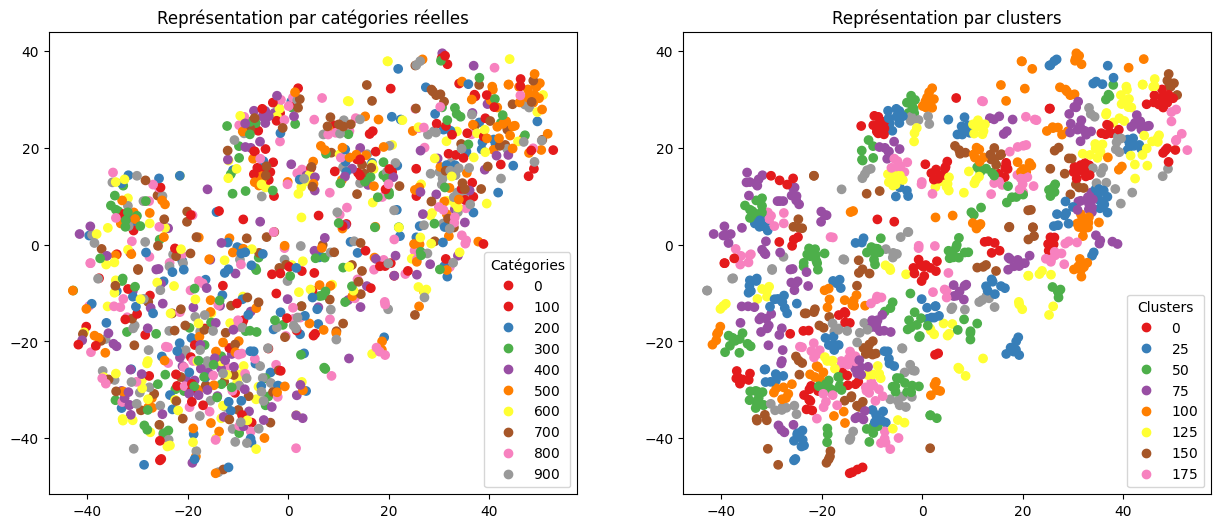

Silhouette Score:  0.39482763


In [63]:
TSNE_visu_fct(X_tsne_use, y_cat, labels_use, silhouette_avg_use)